In [1]:
%load_ext autoreload
%autoreload 2

from typing import List, Dict

import os
import sys
import yaml
sys.path.append('..')

import time
from tqdm import tqdm
from pathlib import Path

import numpy as np
import jax
import jax.numpy as jnp
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import datasets
from ml_collections.config_dict import ConfigDict

import jgnn_utils as jgnn_ut

H0 = 70 * u.km / u.s / u.Mpc
h = (H0 / 100).value
vtilde_u = (u.km / u.s) / (u.kpc / h) / H0
vtilde_u = vtilde_u.to_value(u.dimensionless_unscaled)

%matplotlib inline
plt.style.use('/mnt/home/tnguyen/default.mplstyle')

2024-03-10 17:12:53.471846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 17:12:53.471887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 17:12:53.473031: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-10 17:12:55.794250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
# Read in the generated dataset
dataset_root = "/mnt/ceph/users/tnguyen/dark_camels/point-cloud-diffusion-outputs"
dataset_name = 'vdm/dazzling-leaf-75'
dataset_path = os.path.join(dataset_root, f'{dataset_name}.npz')

dataset = np.load(dataset_path)
gen_samples = dataset['samples']
cond = dataset['cond']
mask = dataset['mask']
truth_samples = dataset['truth']

num_samples = gen_samples.shape[0]
num_cond = cond.shape[1]

# apply mask 
gen_samples = gen_samples * mask[..., None]
truth_samples = truth_samples * mask[..., None]
gen_samples[gen_samples == 0] = np.nan
truth_samples[truth_samples == 0] = np.nan

# vtilde unit
gen_samples[..., 7] = 10**gen_samples[..., 7] * vtilde_u
truth_samples[..., 7] = 10**truth_samples[..., 7] * vtilde_u

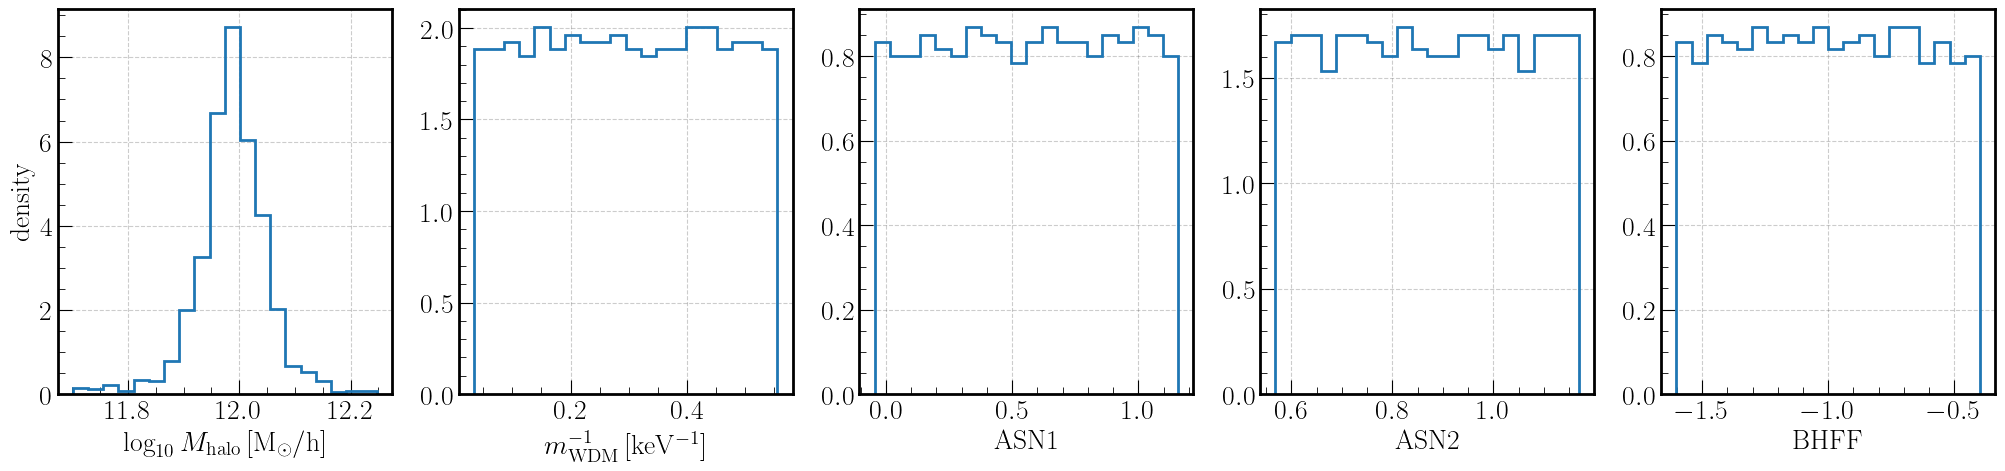

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i in range(5):
    axes[i].hist(cond[:, i], bins=20, 
    histtype='step', lw=2, density=True)

axes[0].set_xlabel(r'$\log_{10} M_\mathrm{halo} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$m^{-1}_\mathrm{WDM} \, [\rm keV^{-1}]$')
axes[2].set_xlabel(r'ASN1')
axes[3].set_xlabel(r'ASN2')
axes[4].set_xlabel(r'BHFF')
axes[0].set_ylabel(r'density')

plt.show()
fig.tight_layout()

In [13]:
# bin the data by the number of conditional parameters
n_bins_per_dim = 5
n_bins = n_bins_per_dim**num_cond
cond_min = cond.min(axis=0)
cond_max = cond.max(axis=0)
bin_edges = [np.linspace(cond_min[i], cond_max[i], n_bins_per_dim + 1) for i in range(num_cond)]

# get the bin indices along each dimension
indices = [np.digitize(cond[:, i], bin_edges[i]) - 1 for i in range(num_cond)]

In [14]:
def get_bins(indices, select):
    """ Return the bin mask for a given selection. """
    mask = np.ones(indices[0].shape, dtype=bool)
    for i, s in zip(indices, select):
        if s is not None:
            mask &= i == s
    return mask

def get_histogram_q(samples, bins, q, cumulative=False, normalized=False):
    """ Compute the qth percentile of a samples of histograms. """
    counts = [np.histogram(samples[i], bins=bins)[0] for i in range(samples.shape[0])]
    counts = np.stack(counts, axis=0)
    if normalized:
        counts = counts / counts.sum(1, keepdims=True)
    if cumulative:
        counts = counts.sum(1, keepdims=True) - np.cumsum(counts, axis=1)

    counts_q = np.nanpercentile(counts, q=q, axis=0)
    return counts_q

In [15]:
gen_samples_bins = []
truth_samples_bins = []
mask_bins = []
cond_bins = []
i_cond = 1
cond_labels = [
    r'$\log_{10} M_\mathrm{halo}$', r'$m^{-1}_\mathrm{WDM}$', 
    r'$\log_{10} \mathrm{ASN1}$', r'$\log_{10} \mathrm{ASN2}$', 
    r'$\log_{10} \mathrm{BHFF}$']

for i in range(n_bins_per_dim):
    select = [None, None, None, None, None]
    select[i_cond] = i
    
    bin_mask = get_bins(indices, select)
    gen_samples_bins.append(gen_samples[bin_mask])
    truth_samples_bins.append(truth_samples[bin_mask])
    mask_bins.append(mask[bin_mask])
    cond_bins.append(cond[bin_mask])

In [16]:
def plot_scatter_bin(
    x, y, ax, num_bins=10, x_min=8, x_max=12, min_bin_count=100, 
    y_min=None, y_max=None, scatter_args=None, errorbar_args=None):
    
    y_min = y_min or -np.inf
    y_max = y_max or np.inf
    default_scatter_args = dict(s=1, alpha=0.2, color='gray')
    default_errorbar_args = dict(fmt='o-', lw=2, color='r', capsize=5)
    if scatter_args is not None:
        default_scatter_args.update(scatter_args)
    if errorbar_args is not None:
        default_errorbar_args.update(errorbar_args)

    # plot the scatter plot
    ax.scatter(x, y, **default_scatter_args)

    # bin by x and plot the median and error bars
    bin_edges = np.linspace(x_min, x_max, num_bins + 1)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    median, low_error, high_error = [], [], []
    for i in range(num_bins):
        mask = (x > bin_edges[i]) & (x < bin_edges[i + 1])
        mask &= (y > y_min) & (y < y_max)
        if mask.sum() < min_bin_count:
            median.append(np.nan)
            low_error.append(np.nan)
            high_error.append(np.nan)
            continue

        y_bin = y[mask]
        med, low, high = np.nanpercentile(y_bin, [50, 16, 84])
        median.append(med)
        low_error.append(med - low)
        high_error.append(high - med)

    ax.errorbar(
        bin_centers, median, yerr=[low_error, high_error], 
        **default_errorbar_args)

    return ax, bin_centers, median, low_error, high_error

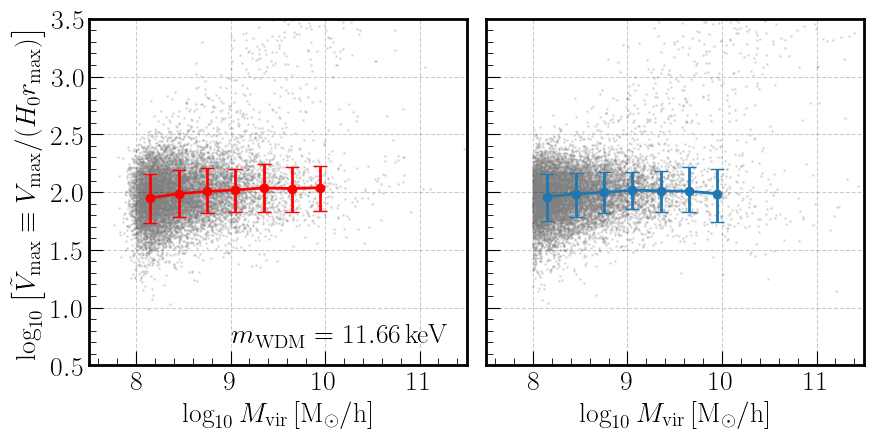

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), sharex=True, sharey=True)

bin_id = 0
min_bin_count = 100
x_min, x_max = 8, 11
y_min, y_max = 1, 2.5

log_mvir = gen_samples_bins[bin_id][::100,..., 6]
vtilde = gen_samples_bins[bin_id][::100,..., 7]
plot_scatter_bin(
    log_mvir, np.log10(vtilde), axes[0], x_min=x_min, x_max=x_max,
    min_bin_count=min_bin_count, y_min=y_min, y_max=y_max)

log_mvir = truth_samples_bins[bin_id][::100, ..., 6]
vtilde = truth_samples_bins[bin_id][::100, ..., 7]
plot_scatter_bin(
    log_mvir, np.log10(vtilde), axes[1], x_min=x_min, x_max=x_max,
    min_bin_count=min_bin_count, y_min=y_min, y_max=y_max,
    errorbar_args=dict(color='C0'))

axes[0].set_xlabel(r'$\log_{10} M_\mathrm{vir} \, [\rm M_\odot / h]$')
axes[1].set_xlabel(r'$\log_{10} M_\mathrm{vir} \, [\rm M_\odot / h]$')
axes[0].set_ylabel(
    r'$\log_{10} \left[\tilde{V}_\mathrm{max} \equiv V_\mathrm{max} / (H_0 r_\mathrm{max})\right]$')

axes[0].set_ylim(0.5, 3.5)
axes[0].set_xlim(7.5, 11.5)
axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
axes[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))

if i_cond == 1:
    text = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[bin_id][:, 1]))
else:
    text = f'{cond_labels[i_cond]}' + r'$ = {{{:.2f}}}$'.format(
        np.mean(cond_bins[bin_id][:, i_cond]))
 
axes[0].text(
    0.95, 0.05, text, transform=axes[0].transAxes, 
    ha='right', va='bottom')

fig.subplots_adjust(wspace=0.05)

plt.show()

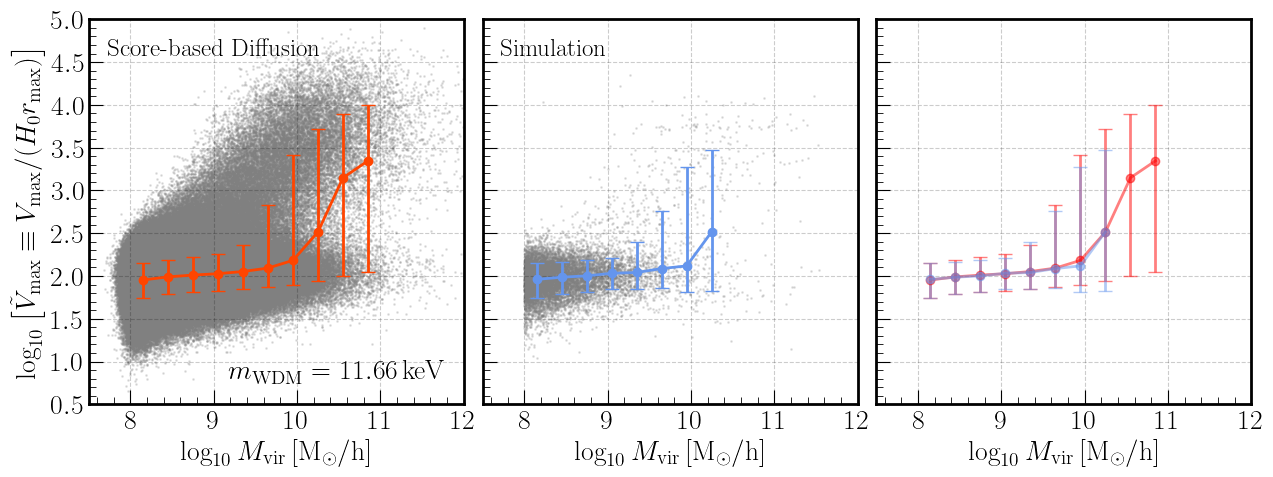

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

bin_id = 0
min_bin_count = 100
x_min, x_max = 8, 11
y_min, y_max = 1, 2.5
y_min, y_max = None, None
gen_label = 'Score-based Diffusion'
truth_label = 'Simulation'
gen_color = 'orangered'
truth_color = 'cornflowerblue'

log_mvir = gen_samples_bins[bin_id][..., 6]
vtilde = gen_samples_bins[bin_id][..., 7]
_, bin_centers, gen_median, gen_low_error, gen_high_error = plot_scatter_bin(
    log_mvir, np.log10(vtilde), axes[0], x_min=x_min, x_max=x_max,
    min_bin_count=min_bin_count, y_min=y_min, y_max=y_max,
    errorbar_args=dict(color=gen_color))

log_mvir = truth_samples_bins[bin_id][::100, ..., 6]
vtilde = truth_samples_bins[bin_id][::100, ..., 7]
_, _, truth_median, truth_low_error, truth_high_error = plot_scatter_bin(
    log_mvir, np.log10(vtilde), axes[1], x_min=x_min, x_max=x_max,
    min_bin_count=min_bin_count, y_min=y_min, y_max=y_max,
    errorbar_args=dict(color=truth_color))

# plot the error bar on top of each other
axes[2].errorbar(
    bin_centers, gen_median, yerr=[gen_low_error, gen_high_error],
    fmt='o-', lw=2, color='r', capsize=5, alpha=0.5)
axes[2].errorbar(
    bin_centers, truth_median, yerr=[truth_low_error, truth_high_error],
    fmt='o-', lw=2, color=truth_color, capsize=5, alpha=0.5)

# format axes
for ax in axes:
    ax.set_xlabel(r'$\log_{10} M_\mathrm{vir} \, [\rm M_\odot / h]$')
axes[0].set_ylabel(
    r'$\log_{10} \left[\tilde{V}_\mathrm{max} \equiv V_\mathrm{max} / (H_0 r_\mathrm{max})\right]$')
axes[0].set_ylim(0.5, 5.0)
axes[0].set_xlim(7.5, 12.0)
axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
axes[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))

# set text
if i_cond == 1:
    text = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
        1/np.mean(cond_bins[bin_id][:, 1]))
else:
    text = f'{cond_labels[i_cond]}' + r'$ = {{{:.2f}}}$'.format(
        np.mean(cond_bins[bin_id][:, i_cond]))
axes[0].text(
    0.95, 0.05, text, transform=axes[0].transAxes, 
    ha='right', va='bottom')
axes[0].text(
    0.05, 0.95, gen_label, transform=axes[0].transAxes,
    ha='left', va='top', fontsize=18)
axes[1].text(
    0.05, 0.95, truth_label, transform=axes[1].transAxes,
    ha='left', va='top', fontsize=18)

fig.subplots_adjust(wspace=0.05)

plt.show()

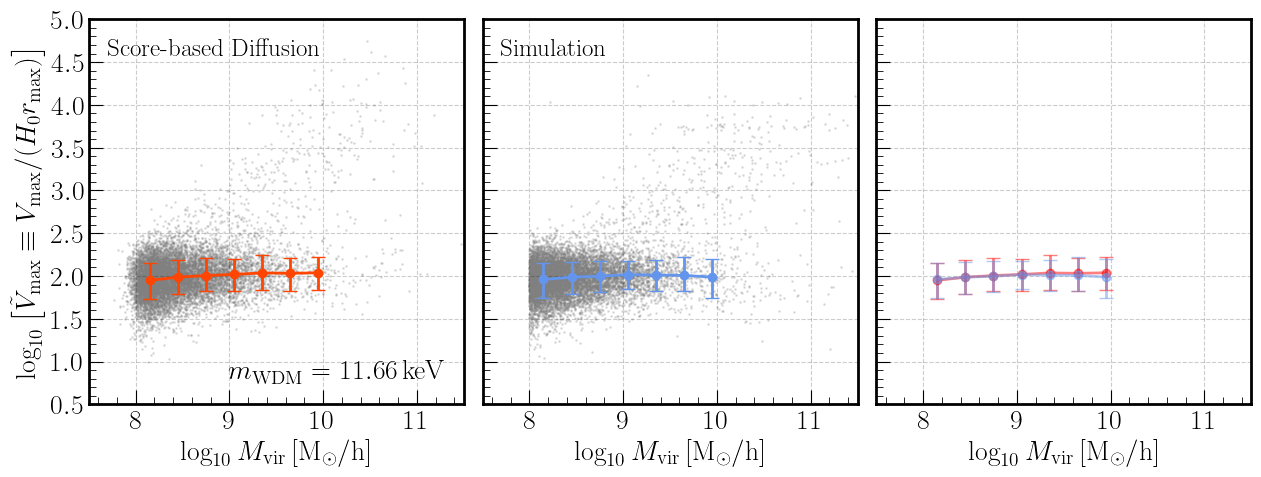

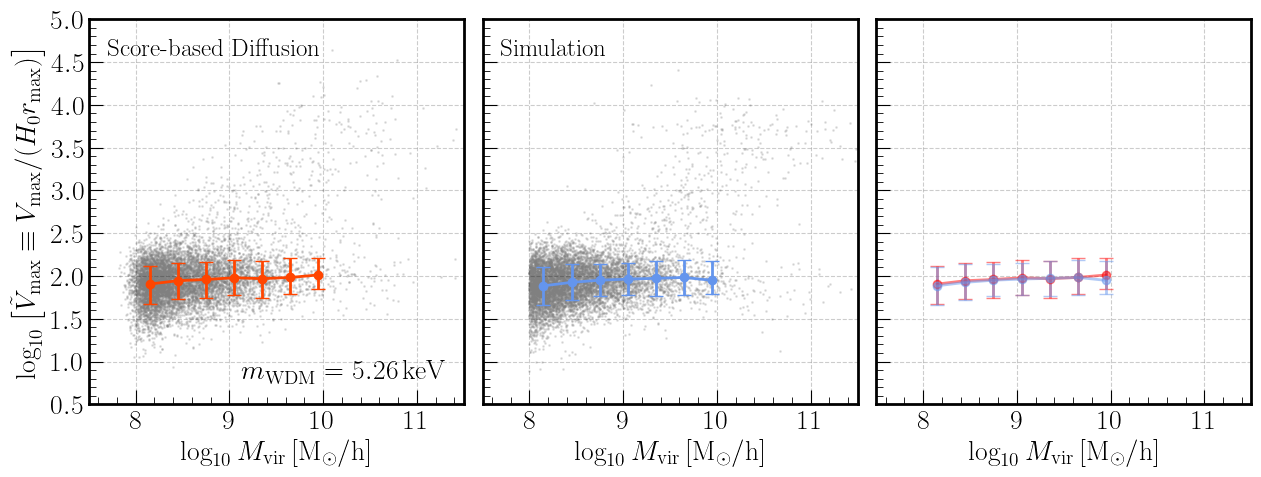

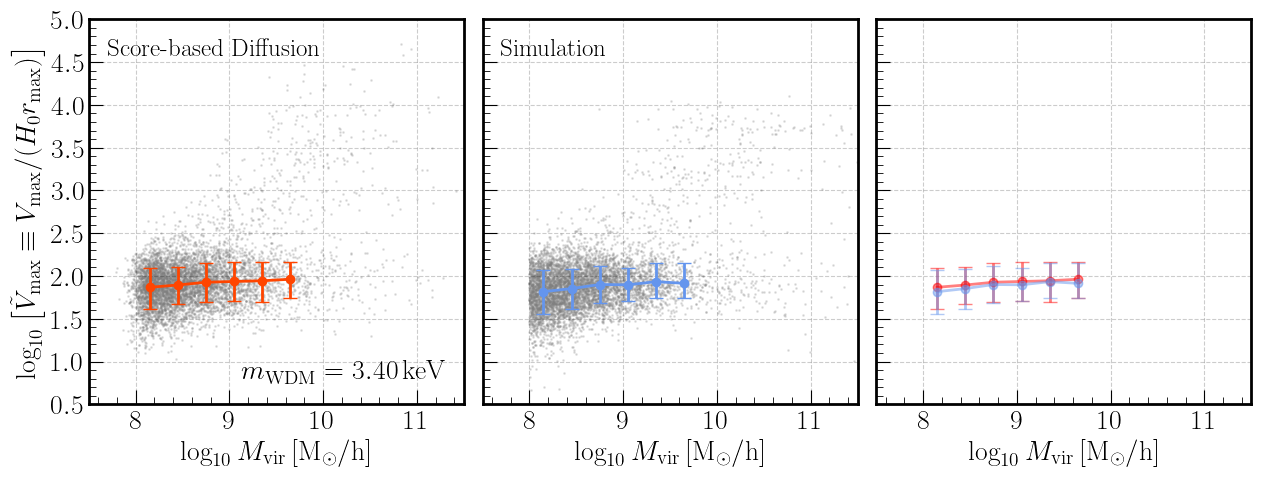

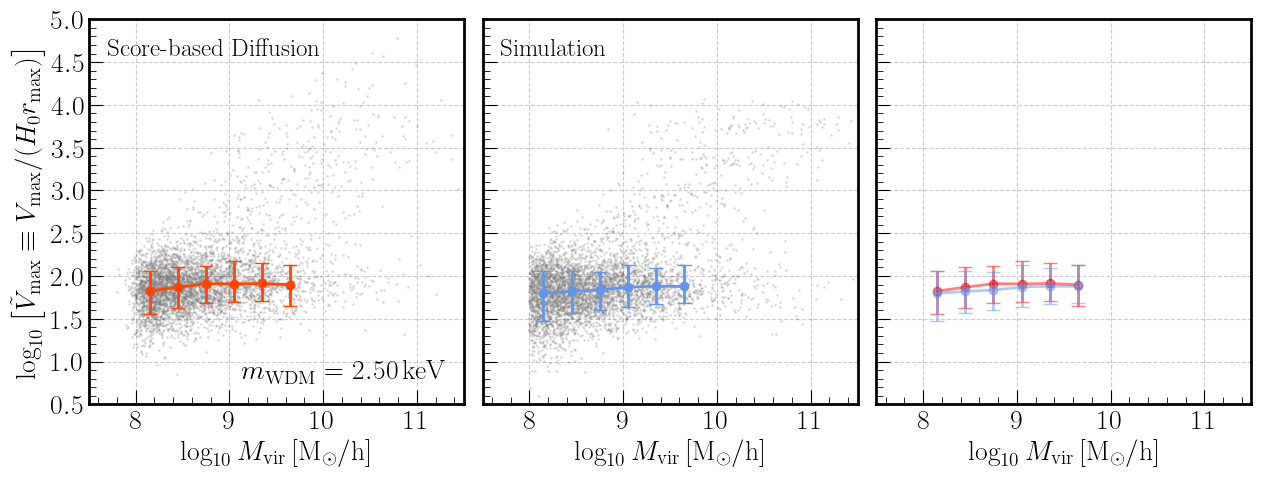

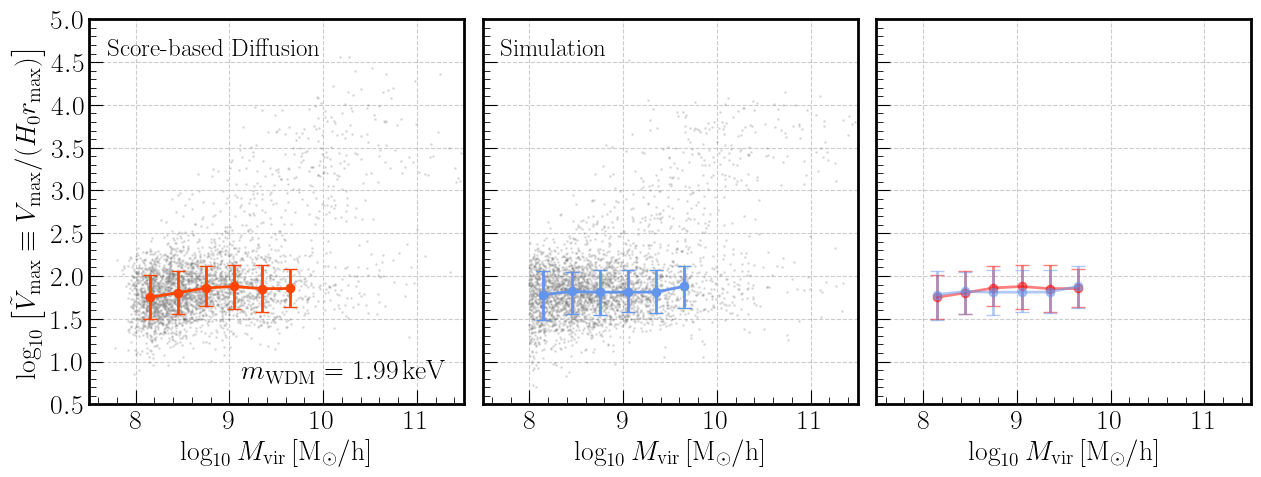

In [19]:
for bin_id in range(n_bins_per_dim):


    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

    min_bin_count = 100
    x_min, x_max = 8, 11
    y_min, y_max = 1, 2.5
    gen_label = 'Score-based Diffusion'
    truth_label = 'Simulation'
    gen_color = 'orangered'
    truth_color = 'cornflowerblue'

    log_mvir = gen_samples_bins[bin_id][::100,..., 6]
    vtilde = gen_samples_bins[bin_id][::100,..., 7]
    _, bin_centers, gen_median, gen_low_error, gen_high_error = plot_scatter_bin(
        log_mvir, np.log10(vtilde), axes[0], x_min=x_min, x_max=x_max,
        min_bin_count=min_bin_count, y_min=y_min, y_max=y_max,
        errorbar_args=dict(color=gen_color))

    log_mvir = truth_samples_bins[bin_id][::100, ..., 6]
    vtilde = truth_samples_bins[bin_id][::100, ..., 7]
    _, _, truth_median, truth_low_error, truth_high_error = plot_scatter_bin(
        log_mvir, np.log10(vtilde), axes[1], x_min=x_min, x_max=x_max,
        min_bin_count=min_bin_count, y_min=y_min, y_max=y_max,
        errorbar_args=dict(color=truth_color))

    # plot the error bar on top of each other
    axes[2].errorbar(
        bin_centers, gen_median, yerr=[gen_low_error, gen_high_error],
        fmt='o-', lw=2, color='r', capsize=5, alpha=0.5)
    axes[2].errorbar(
        bin_centers, truth_median, yerr=[truth_low_error, truth_high_error],
        fmt='o-', lw=2, color=truth_color, capsize=5, alpha=0.5)

    # format axes
    for ax in axes:
        ax.set_xlabel(r'$\log_{10} M_\mathrm{vir} \, [\rm M_\odot / h]$')
    axes[0].set_ylabel(
        r'$\log_{10} \left[\tilde{V}_\mathrm{max} \equiv V_\mathrm{max} / (H_0 r_\mathrm{max})\right]$')
    axes[0].set_ylim(0.5, 5)
    axes[0].set_xlim(7.5, 11.5)
    axes[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.5))
    axes[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))

    # set text
    if i_cond == 1:
        text = r'$m_\mathrm{{WDM}} = {{{:.2f}}} \, \mathrm{{keV}}$'.format(
            1/np.mean(cond_bins[bin_id][:, 1]))
    else:
        text = f'{cond_labels[i_cond]}' + r'$ = {{{:.2f}}}$'.format(
            np.mean(cond_bins[bin_id][:, i_cond]))
 
    axes[0].text(
        0.95, 0.05, text, transform=axes[0].transAxes, 
        ha='right', va='bottom')
    axes[0].text(
        0.05, 0.95, gen_label, transform=axes[0].transAxes,
        ha='left', va='top', fontsize=18)
    axes[1].text(
        0.05, 0.95, truth_label, transform=axes[1].transAxes,
        ha='left', va='top', fontsize=18)

    fig.subplots_adjust(wspace=0.05)

    plt.show()